In [1]:
import warnings
import time
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from IPython import display
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, homogeneity_score, completeness_score, v_measure_score
from sklearn.cluster import KMeans # а также другие алгоритмы

In [2]:
DATA_PATH = "../data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Реализация Kmeans

5 баллов

В данном задании вам предстоит дописать код класса `MyKMeans`. Мы на простом примере увидим, как подбираются центры кластеров и научимся их визуализировать.

Сгенерируем простой набор данных, 400 объектов и 2 признака (чтобы все быстро работало и можно было легко нарисовать):

In [3]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])

Напишем функцию `visualize_clusters`, которая по данным и меткам кластеров будет рисовать их и разукрашивать:

In [4]:
def visualize_clusters(X, labels):
    """
    Функция для визуализации кластеров
        :param X: таблица объекты х признаки
        :param labels: np.array[n_samples] - номера кластеров
    """
    
    unique_labels = np.sort(np.unique(labels))
    sns.scatterplot(X[:, 0], X[:, 1], hue=labels, 
                    palette="colorblind", legend=False,
                    hue_order=unique_labels)
    
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)
    
    for label in labels:
        center = X[(labels == label)].mean(axis=0)
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

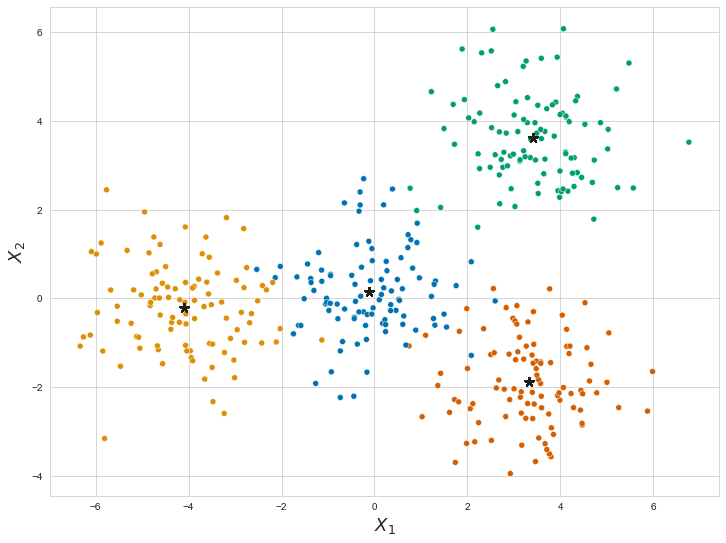

In [5]:
visualize_clusters(X, true_labels)

Напишем свой класс `MyKMeans`, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

1. Выбераем число кластеров (K)
2. Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
3. Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайщего
4. Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
5. Этот "центр масс" становится новым центром кластера
6. Повторяем п.3, 4, 5 заданное число итераций или до сходимости

Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Реализуйте методы:
* `_calculate_distance(X, centroid)` - вычисляет Евклидово расстояние от всех объектов в `Х` до заданного центра кластера (`centroid`)
* `predict(X)` - для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент

In [6]:
class MyKMeans:
    def __init__(self, n_clusters, init="random", max_iter=300, visualize=False):
        """
        Конструктор класса MyKMeans
            :param n_clusters: число кластеров
            :param init: способ инициализации центров кластеров
                'random' - генерирует координаты случайно из нормального распределения
                'sample' - выбирает центроиды случайно из объектов выборки
            :param max_iter: заданное число итераций 
                (мы не будем реализовывать другой критерий остановки)
            :param visualize: рисовать ли кластеры и их центроиды в процессе работы
                код будет работать сильно дольше, но красиво...
        """
        
        assert init in ["random", "sample"], f"Неизвестный метод инициализации {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize
       
    
    def fit(self, X):
        """
        Подбирает оптимальные центры кластеров
            :param X: наши данные (n_samples, n_features)
        :return self: все как в sklearn
        """
        
        n_samples, n_features = X.shape
        
        # Инициализация центров кластеров
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, n_features)
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples), 
                                             size=self.n_clusters, 
                                             replace=False)
            centroids = X[centroids_idx]
        
        # Итеративно двигаем центры
        for _ in range(self.max_iter):
            # Посчитаем расстояния для всех объектов до каждого центроида
            dists = []
            for centroid in centroids:
                dists.append(self._calculate_distance(X, centroid))
            dists = np.concatenate(dists, axis=1)
            
            # Для каждого объекта найдем, к какому центроиду он ближе
            cluster_labels = np.argmin(dists, axis=1)
            
            # Пересчитаем центр масс для каждого кластера
            centroids = []
            for label in np.sort(np.unique(cluster_labels)):
                center = X[(cluster_labels == label)].mean(axis=0)
                centroids.append(center)
            
            # Отрисуем точки, покрасим по меткам кластера, а также изобразим центроиды
            if self.visualize:
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()
        
        # записываем финальные значения координат центроидов 
        self.centroids = np.array(centroids)
        
        return self
    
    
    def predict(self, X):
        """
        Для каждого X возвращает номер кластера, к которому он относится
            :param X: наши данные (n_samples, n_features)
        :return cluster_labels: метки кластеров
        """
        # посчитаем расстояния до центроидов
        dists = []
        for centroid in self.centroids:
            dists.append(self._calculate_distance(X, centroid))
        dists = np.concatenate(dists, axis=1)
        
        # Для каждого объекта найдем, к какому центроиду он ближе
        cluster_labels = np.argmin(dists, axis=1)
            
        return cluster_labels
        
        
    def _calculate_distance(self, X, centroid):
        """
        Вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
            :param X: наши данные (n_samples, n_features)
            :param centroid: координаты центра кластера
        :return dist: расстояния от всех X до центра кластера
        """
        # broadcasting 
        dist = X[:,None,:] - centroid[None,None,:]
        
        # Square each distance
        dist = dist ** 2

        # Take the sum of each coordinates distance (the result will be 2D)
        dist = np.sum(dist, axis=2)

        # And take the square root
        dist = np.sqrt(dist)
        
        return dist
    
    
    def __repr__(self):
        return f"Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*"

Обучите `MyKMeans` на наших игручешных данных, добейтесь сходимости. Не забудьте поставить `visualize=True`, чтобы посмотреть на красивые картинки. Также попробуйте различные способы инициализации центроидов и скажите, какой лучше подошел в этой ситуации.

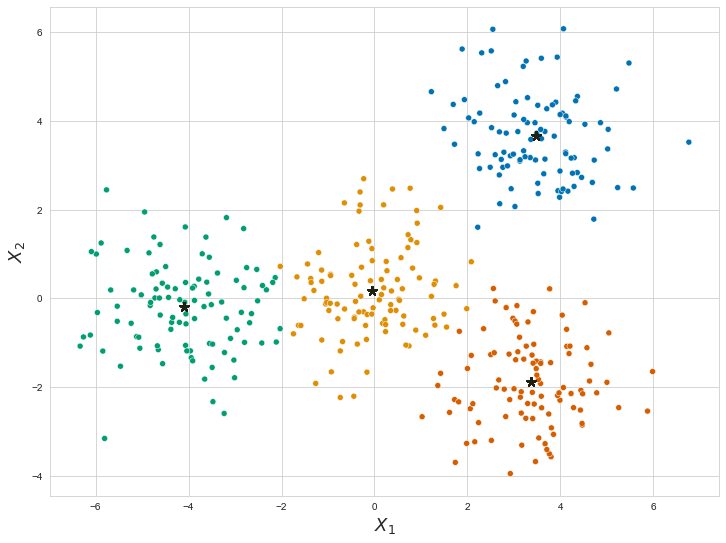

In [7]:
model_random = MyKMeans(n_clusters=4, init="random", max_iter=15, visualize=True).fit(X)

In [8]:
# проверим, что найдены центроиды, сопоставимые с заданными
# centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]]
model_random.centroids

array([[ 3.48057477,  3.64682795],
       [-0.05381062,  0.16768302],
       [-4.09935775, -0.19762573],
       [ 3.35979583, -1.88515059]])

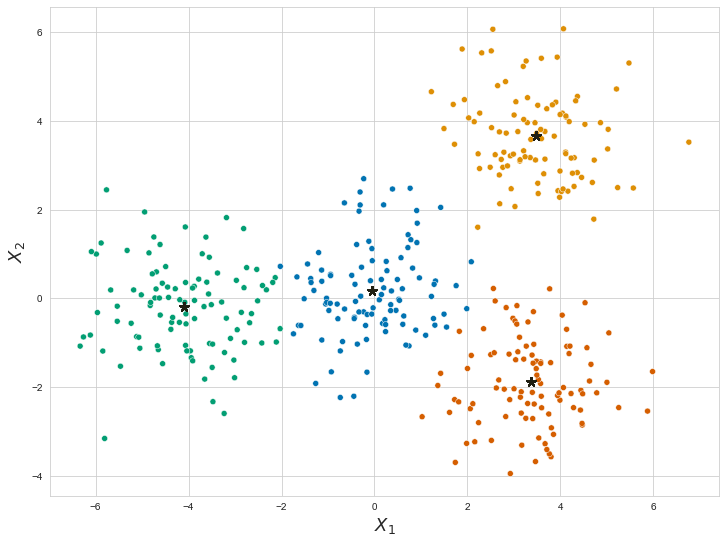

In [9]:
model_sample = MyKMeans(n_clusters=4, init="sample", max_iter=15, visualize=True).fit(X)

In [10]:
# проверим, что найдены заданные центроиды
# centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]]
model_sample.centroids

array([[-0.05381062,  0.16768302],
       [ 3.48057477,  3.64682795],
       [-4.09935775, -0.19762573],
       [ 3.35979583, -1.88515059]])

**При построении визуалзиации обучения модели видно, что центры кластеров сходятсмя довольно быстро. Количество итераций 300 более чем избыточно, хватает и 15.   
Либо стоит добавить в алгоритм метрику, которая остановит кластеризацию при ее сходимости.**
  
**Явно ощутимой разницы между способами инициализации кластеров не наблюдается. Оба быстро сходятся к истинным значениям центроид.**

### Задание 2. Подбираем лучшую иерархическую кластеризацию

5 баллов

На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure
* silhouette

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Загрузим наши данные:

In [11]:
data = load_digits()
X, y = data.data, data.target

In [12]:
print(X.shape)
print(np.unique(y), len(np.unique(y)))

(1797, 64)
[0 1 2 3 4 5 6 7 8 9] 10


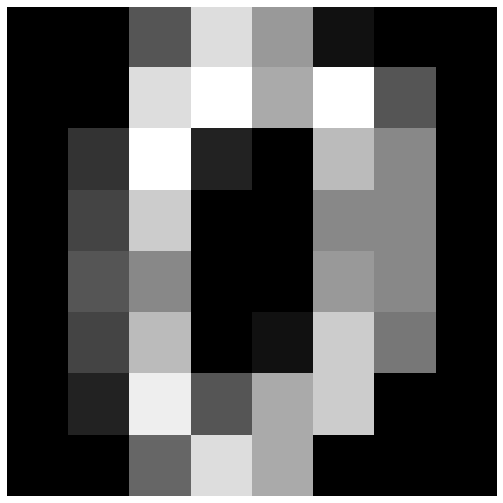

In [13]:
plt.imshow(X[0].reshape(8, 8).astype(int), cmap="gray")
plt.axis("off");

Работать будем с изображениями рукописных цифр. Тут все похоже на данные для 1 домашнего задания, каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать `reshape` в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции `algorithm_selection`, которую вы реализуете. Для некоторых метрик кластеризации требуются метки **классов** объектов (они хранятся в переменной `y`). Укажите для каждого алгоритма число кластеров равное количеству классов в `y`.

##### YOUR TURN TO CODE

In [14]:
from sklearn.cluster import AgglomerativeClustering

In [15]:
def algorithm_selection(X, y, distances, algorithms, metrics, n_clusters):
    """
    Для заданных алгоримов кластеризации и гиперпараметров 
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param distances: список возможных метрик расстояния
        :param algorithm: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации
    :return compare_dataframe: таблица с метриками кластеризации
    """
    # массив для записи метрик соответствующих параметров
    compare_data = []
    # словарь функций-метрик
    metric_func = {'Homogeneity': homogeneity_score, 'Completeness': completeness_score,
                   'V-measure': v_measure_score, 'Silhouette': silhouette_score}
    
    for dist in distances:
        for alg in algorithms:
                
                model = AgglomerativeClustering(n_clusters=n_clusters, affinity=dist, linkage=alg).fit(X)
                
                new_row = [dist, alg]
                
                # словарик с функциями позволяет задавать метрики в любом порядке
                for metric in metrics:
                    if metric == 'Silhouette':
                        new_row.append(metric_func[metric](X, model.labels_))
                    else:
                        new_row.append(metric_func[metric](y, model.labels_))
        
                compare_data.append(new_row)
    
    # преобразуем результаты в dataframe
    cols = ['distance', 'linkage'] + metrics
    compare_dataframe = pd.DataFrame(compare_data, columns = cols)
    
    return compare_dataframe

In [16]:
distances = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
algorithms = ['average', 'single', 'complete']
metrics = ['Homogeneity', 'Completeness', 'V-measure', 'Silhouette']

compare_dataframe = algorithm_selection(X, y, distances, algorithms, metrics, 10)
compare_dataframe.sort_values('V-measure')

distance   linkage  Homogeneity  Completeness  V-measure  Silhouette
13     cosine    single     0.005050      0.273389   0.009916   -0.158250
1   euclidean    single     0.005056      0.273755   0.009929   -0.133621
7          l2    single     0.005056      0.273755   0.009929   -0.133621
4          l1    single     0.005102      0.276237   0.010019   -0.166627
10  manhattan    single     0.005102      0.276237   0.010019   -0.166627
14     cosine  complete     0.528727      0.577415   0.551999    0.088021
2   euclidean  complete     0.590549      0.637772   0.613253    0.119271
8          l2  complete     0.590549      0.637772   0.613253    0.119271
3          l1   average     0.566751      0.778942   0.656117    0.089217
9   manhattan   average     0.566751      0.778942   0.656117    0.089217
5          l1  complete     0.646372      0.686109   0.665648    0.140183
11  manhattan  complete     0.646372      0.686109   0.665648    0.140183
0   euclidean   average     0.655393      0.782342   0.713263    0.146625
6          l2   average     0.655393      0.782342   0.713263    0.146625
12     cosine   average     0.648268      0.808762   0.719676    0.129526

<font size=3 color='blue'><b>При сортировке по V-скору очень четко видно и градацию других параметров. Видно, что avarage linkage обеспечивает лучшие метрики однородности и полноты (и соответственно V-скора). Им также соответствует наилучшее значение силуэта. Значительной разницей между euclidian, l2 и cosine distance нет, хотя первые две обсепечивают лучший результат.<br></b></font>

### Задание 3. Аннотация клеточных типов

суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы **FSC-A**, **SSC-A** косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

#### 3.1. EDA

1.5 балла

Проведите EDA:

1. Посмотрите на данные (можно попробовать метод `describe`)
2. Сколько у нас клеток / признаков
3. Постройте распределения каждого признака (есть ли очевинные выбросы?)

In [17]:
fc_data = pd.read_csv(join(DATA_PATH, "flow_c_data.csv"), index_col=0)

In [18]:
fc_data.head()

FSC-A     SSC-A    HLA-DR       CD3      CD45      CD14      CD56  \
0  0.722199  0.154232  0.494449  0.512853  4.057328  1.019255  4.007273   
1  0.751073  0.114618  4.671924  0.822042  4.933149  0.159388 -0.216407   
2  1.108188  0.150011 -0.422857  4.006353  5.616384  0.519223  0.783077   
3  0.553310  0.119929  0.345968  3.332310  5.260935  1.481229  0.264846   
4  0.774884  0.076984  4.984963  0.885501  4.562367  0.217117  0.086279   

       CD19     CD11c  
0 -1.406912  0.384406  
1  6.034845  0.577039  
2 -0.318668 -0.493832  
3  0.694883  3.416960  
4  5.563345  0.471591

In [19]:
fc_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FSC-A   10000 non-null  float64
 1   SSC-A   10000 non-null  float64
 2   HLA-DR  10000 non-null  float64
 3   CD3     10000 non-null  float64
 4   CD45    10000 non-null  float64
 5   CD14    10000 non-null  float64
 6   CD56    10000 non-null  float64
 7   CD19    10000 non-null  float64
 8   CD11c   10000 non-null  float64
dtypes: float64(9)
memory usage: 781.2 KB


In [20]:
fc_data.describe()

FSC-A         SSC-A        HLA-DR           CD3          CD45  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.962458      0.165415      1.791579      3.280391      5.169845   
std        0.500012      0.190773      2.027281      2.112079      0.518247   
min        0.144786      0.021657     -7.634172     -2.517639     -8.329666   
25%        0.798804      0.105550      0.275056      1.401943      4.922227   
50%        0.908574      0.130543      1.194313      4.373660      5.234119   
75%        1.052034      0.162536      3.696976      4.842212      5.481218   
max       42.954485     15.460997     12.946668     13.844391     13.710922   

               CD14          CD56          CD19         CD11c  
count  10000.000000  10000.000000  10000.000000  10000.000000  
mean       1.097182      0.412223      1.219683      0.569898  
std        1.375876      1.176967      2.285305      1.502445  
min       -8.833883    -12.358701     -9.640775    -11.085437  
25%        0.389746     -0.195978     -0.146948     -0.498781  
50%        0.672853      0.053267      0.244121      0.272297  
75%        1.065076      0.378576      0.908374      1.220576  
max        6.294236      6.461899      7.208721      6.840864

- Данные содержат информацию о 10 тыс. клеток. Всего на каждую клетку приходится 9 фичей.
- Данные не содержат пропусков
- В целом, фичи имеют одинаковый порядок значений, изучим подробнее их распределения:

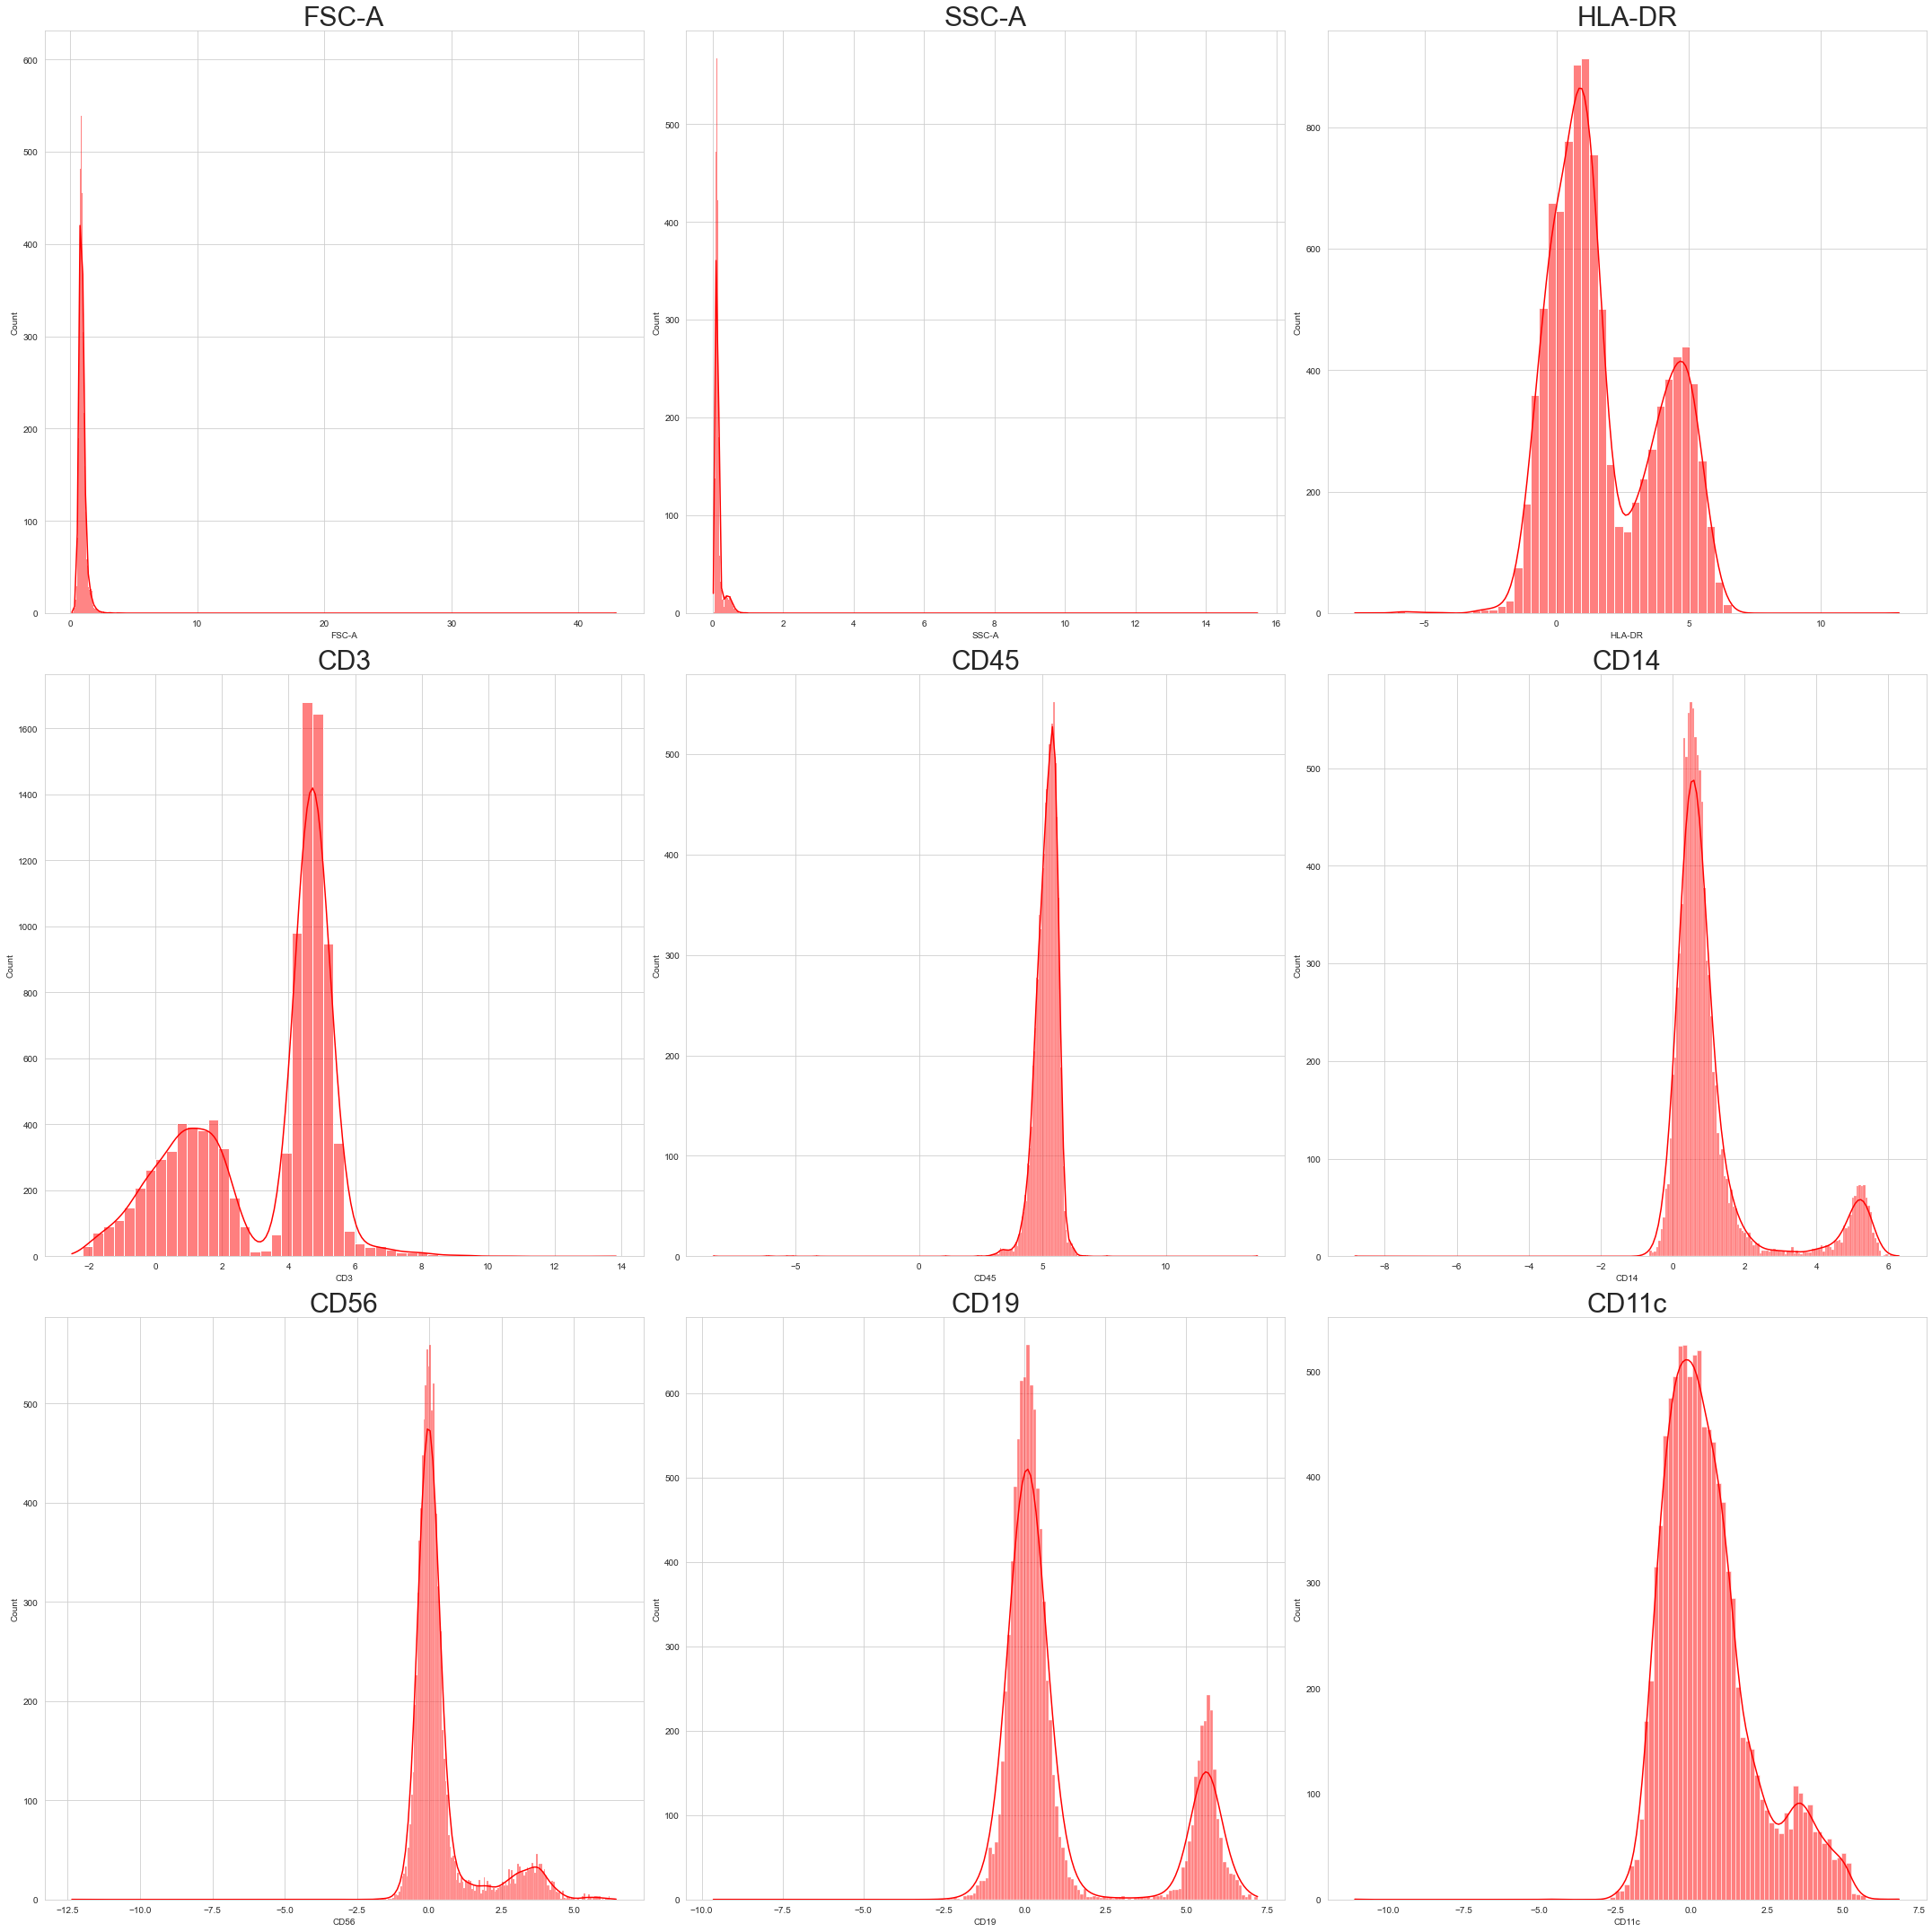

In [21]:
# распределения параметров
fig, axes = plt.subplots(3, 3, figsize=(30, 30))
axes = axes.flatten()

for i, f in enumerate(list(fc_data.columns)):
    sns.histplot(fc_data[f], color = 'r', kde=True, ax=axes[i], label=f)
    axes[i].set_title(f, fontsize=30)
    plt.grid()
    plt.tight_layout()

<font size=3 color='blue'><b>**Вид графиков свидетельствует о том, что в фичах есть явные выбросы.   
Кстати, многие параметры бимодальны, что является явным плюсом для кластеризации**  
Визуализируем дополнительно при помощи violin plot:<br></b></font>

(-10.0, 15.0)

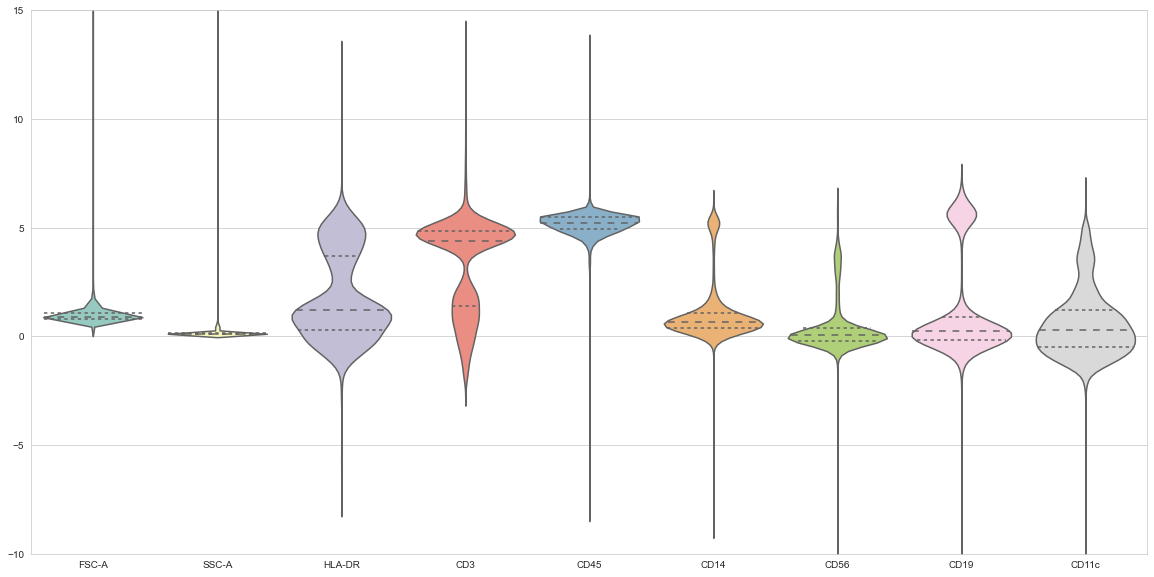

In [22]:
# violin plot
plt.figure(figsize=(20,10))
sns.violinplot(data=fc_data, inner="quartile", scale="width", palette="Set3")
plt.ylim((-10, 15)) #при этом некоторое количество выбросов выходит за диапазон, чтобы их увидеть - удалить стрчоку 

<AxesSubplot:>

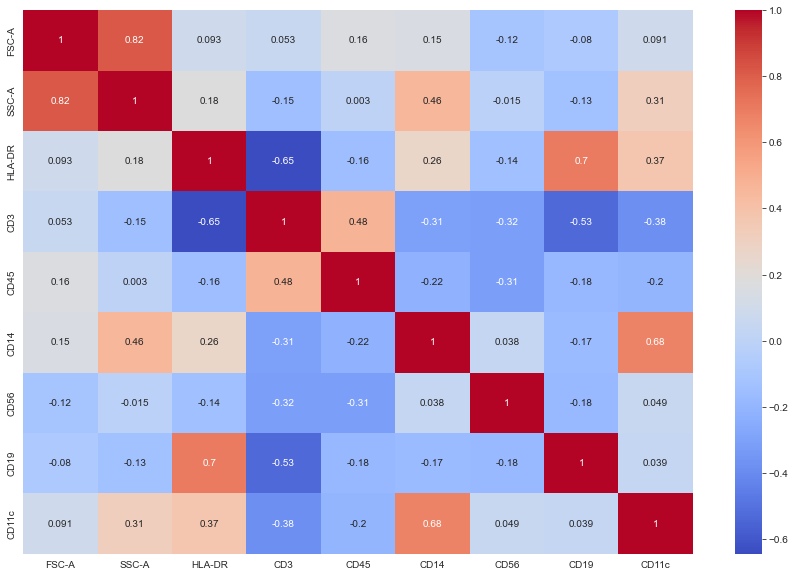

In [23]:
# корреляция между переменными 
plt.figure(figsize=(15,10))
sns.heatmap(fc_data.corr(), cmap="coolwarm", annot = True)

<font size=3 color='blue'><b>Между некоторыми параметрами есть корреляции, но в целом их не слишком много и они не должны сильно испортить кластеризаци.     
Можно предположить, что скоррелированные маркеры объединяют клетки одного типа.<br></b></font>

#### 3.2. Кластеризация

4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

1. При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
2. Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
3. Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
4. После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип

Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE.

Поиграться с красивой визуализацией можно [тут](https://distill.pub/2016/misread-tsne/).

In [24]:
def plot_tsne(data, n_iter=1000, 
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: 
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """
    
    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)
    
    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа, 
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
    tsne_embedding = tnse.fit_transform(pca_embedding)
    
    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding

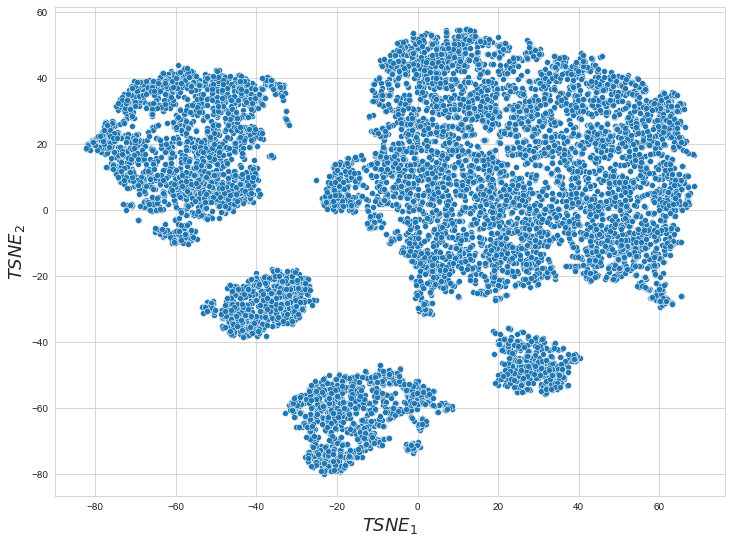

In [25]:
tsne_res = plot_tsne(fc_data)

Кластеризуйте ваши данные:

1. Попробуйте методы кластеризации из тех, что мы прошли
2. Выберите лучший на основании метрики `silhouette_score` (попробуйте также подобрать гиперпараметры)
3. Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

## Опробуем k-means

In [26]:
X = fc_data.to_numpy()
X.shape

(10000, 9)

<font size=3 color='blue'><b>Результат работы k-means сильно зависит от количества итераций, которые мы зададим. Посмотрим на это визуально. (Забежав вперед можно увидеть, что у нас 4 типа клеток, но тут будем инициировать 5 кластеров, иначе слишком большая склонность у алгоритма к объединению и делению не тех кластеров, которые выделяются при аннотации далее)<br></b></font>

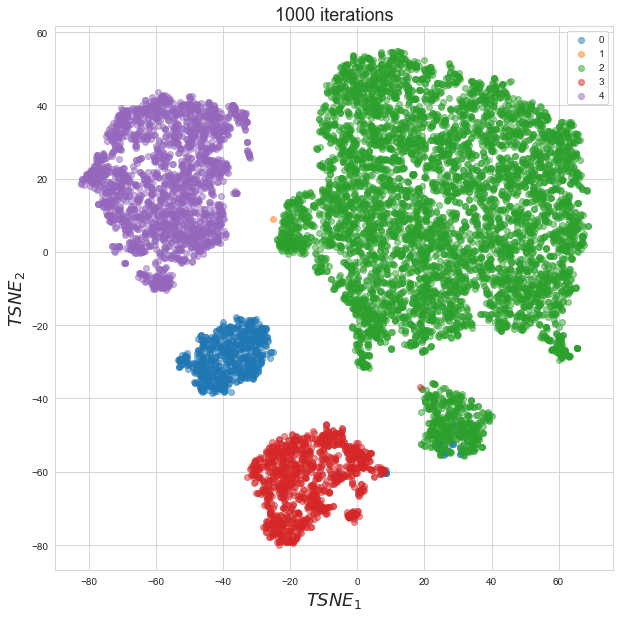

In [27]:
steps = [s for s in range(100, 1100, 100)]

for s in steps:
    model_kmeans = MyKMeans(n_clusters=5, init="random", max_iter=s, visualize=False).fit(X)
    labels_kmeans = model_kmeans.predict(X)
    
    # построи tSNE график, окрасив данные по соответствующим классам
    plt.figure(figsize=(10,10))

    labels = np.unique(labels_kmeans)
    for l in labels:
        cluster = tsne_res[(labels_kmeans == l), :]
        plt.scatter(cluster[:, 0], cluster[:, 1], alpha=0.5, label=l) 
    
    plt.legend()
    plt.title(f"{s} iterations", fontsize=18)
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(1)
    plt.close()

<font size=3 color='blue'><b>Наблюдение: если использовать инициализацию кластеров sample, то алгоритм более склонен к тому, чтобы разделить большой кластер, предсказанный tSNE на несколько других. Видимо при работе с данными большой размерности, в которых есть крупные кластеры - лучше использовать генерацию random. В противном случае мы больше рискуем инициализировать в большом кластере два центроида и разделить его.<br></b></font>
      
  
<font size=3 color='blue'><b>Воспользуемся silhouette_score, чтобы подобрать оптимальные условия кластеризации:<br></b></font>

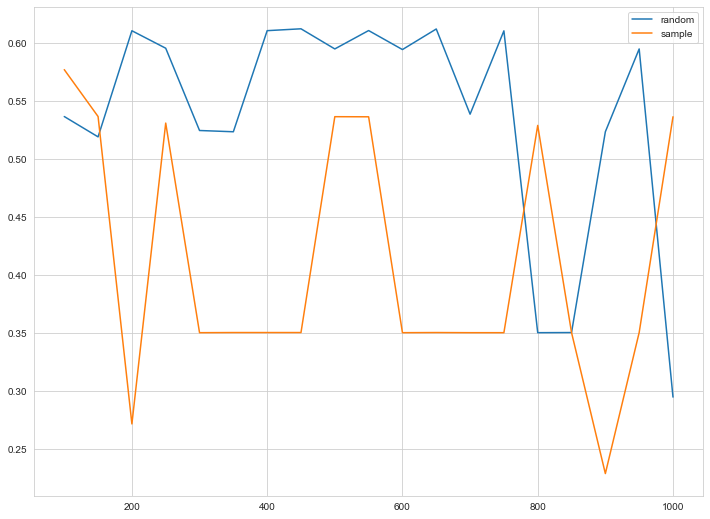

In [28]:
steps = [s for s in range(100, 1050, 50)]
scores_random = []
scores_sample = []

for s in steps:
    model_kmeans = MyKMeans(n_clusters=5, init="random", max_iter=s, visualize=False).fit(X)
    labels_kmeans = model_kmeans.predict(X)
    scores_random.append(silhouette_score(X, labels_kmeans))
    
    model_kmeans = MyKMeans(n_clusters=5, init="sample", max_iter=s, visualize=False).fit(X)
    labels_kmeans = model_kmeans.predict(X)
    scores_sample.append(silhouette_score(X, labels_kmeans))

plt.plot(steps, scores_random, label='random')
plt.plot(steps, scores_sample, label='sample')
plt.legend()

- Вид графика меняется от запуска к запуску в силу эффекта случайности при генерации начальных точек. 
- Видно, что для инициализации random в среднем метрика оказывается выше.
- Метрика в целом нестабильна. По видимому, в силу многомерности данных и нестабильности образуемых кластеров
- **выделим некоторые оптимальные центроиды и запоним их (это сделано с забегом вперед и учетом того, что у нас на самом деле 4 типа клеток и соответственно 4 кластера)**  

0.6103014000983127


Text(0, 0.5, '$TSNE_2$')

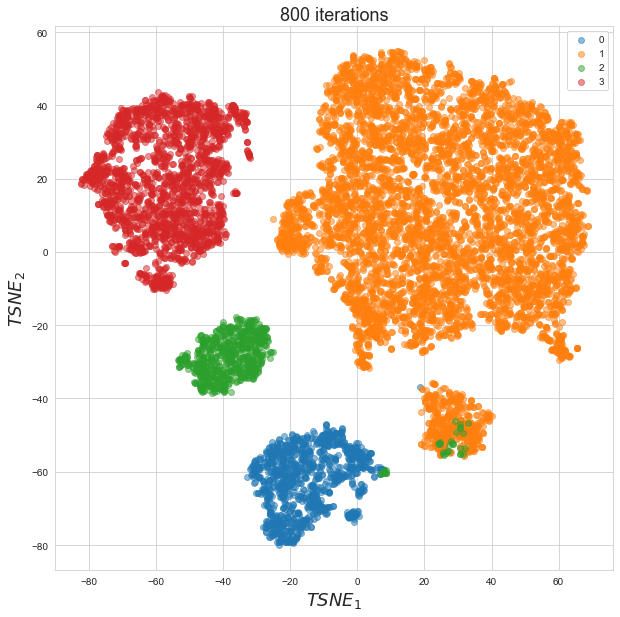

In [29]:
model_optimized = MyKMeans(n_clusters=5, init="random", max_iter=800, visualize=False)

# подобрали и сразу инициировали модель с подходящими центроидами
model_optimized.centroids = np.array([[ 1.22556139, 0.43964443, 3.67116374, 0.91497499, 4.80517419, 4.66901449, 0.51036388, 0.11361737, 3.70473362],
[ 0.94964341, 0.13151232, 0.64686395, 4.78800854, 5.36074166, 0.6982022 , 0.15514932, 0.11660677, 0.01563188],
[ 0.84279312, 0.16203184, 0.3461027 , 0.37828284, 4.5723394 , 0.5552488 , 3.70841407, -0.10655025, 0.28726948],
[ 0.89992224, 0.12285114, 4.74978743, 0.90998903, 4.98048418, 0.5771048 , 0.05635615, 5.61231314, 0.67193921]])

labels_kmeans = model_optimized.predict(X)
print(silhouette_score(X, labels_kmeans))

# построи tSNE график, окрасив данные по соответствующим классам
plt.figure(figsize=(10,10))

labels = np.unique(labels_kmeans)
for l in labels:
    cluster = tsne_res[(labels_kmeans == l), :]
    plt.scatter(cluster[:, 0], cluster[:, 1], alpha=0.5, label=l) 

plt.legend()
plt.title(f"800 iterations", fontsize=18)
plt.xlabel("$TSNE_1$", fontsize=18)
plt.ylabel("$TSNE_2$", fontsize=18)

## Иерархическая кластеризация  
  
Подберем оптимальные параметры с использованием написанной функции:

In [30]:
distances = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
algorithms = ['average', 'single', 'complete']
metrics = ['Silhouette']

compare_dataframe = algorithm_selection(X, y, distances, algorithms, metrics, 6)
compare_dataframe.sort_values('Silhouette')

distance   linkage  Silhouette
1   euclidean    single    0.197963
7          l2    single    0.197963
13     cosine    single    0.197963
5          l1  complete    0.478745
11  manhattan  complete    0.478745
2   euclidean  complete    0.506237
8          l2  complete    0.506237
0   euclidean   average    0.511261
6          l2   average    0.511261
4          l1    single    0.594182
10  manhattan    single    0.594182
14     cosine  complete    0.605815
3          l1   average    0.610305
9   manhattan   average    0.610305
12     cosine   average    0.613119

**Здесь я намеренно увеличил число кластеров, потому что при количестве равном 4 - происходит слияние всех кластеров в один (остальные три представлены единичными точками). Более адекватный результат получается при большем числе кластеров.**

**Наибольшее значение метрики получается для average linkage для метрик l1, cosine и manhattan.**
  
**Взуализируем 3 варианта:**

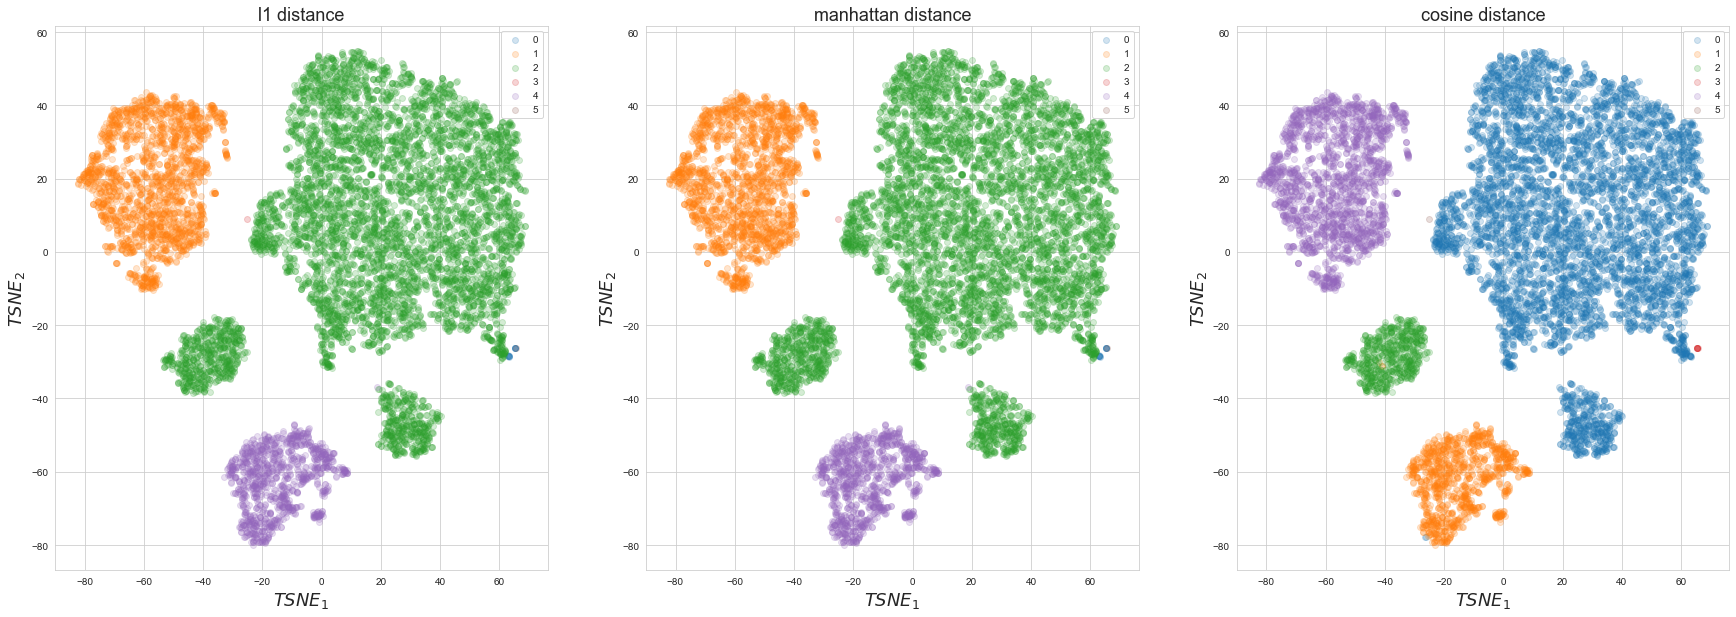

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
axes = axes.flatten()

for i, f in enumerate(['l1', 'manhattan', 'cosine']):
    agg_model = AgglomerativeClustering(n_clusters=6, affinity=f, linkage='average').fit(X)
    agg_labels = agg_model.labels_
    
    for label in np.unique(agg_labels):
        cluster = tsne_res[(agg_labels == label), :]
        axes[i].scatter(cluster[:, 0], cluster[:, 1], alpha=0.2, label=label) 

    axes[i].legend()
    axes[i].set_title(f"{f} distance", fontsize=18)
    axes[i].set_xlabel("$TSNE_1$", fontsize=18)
    axes[i].set_ylabel("$TSNE_2$", fontsize=18)

<font size=3 color='blue'><b>Вариант с cosine distance показывает наилучший результат, согласующийся с аннотацией клеточных типов. Метрика силуета несколько лучше, чем для k-means. Визуально видно, что куда меньше точек, отнесены к неверному кластеру. Правда есть и небольшой осложняющий фактор: кластеры 5 и 3 необходимо слить с 0. Здесь смиримся, но вообще такакя ручная корректировка - потенциальный источник ошибок. <br></b></font>
  
## DBSCAN

In [32]:
from sklearn.cluster import DBSCAN

**Изучим влияние параметра eps на количество кластеров:**  

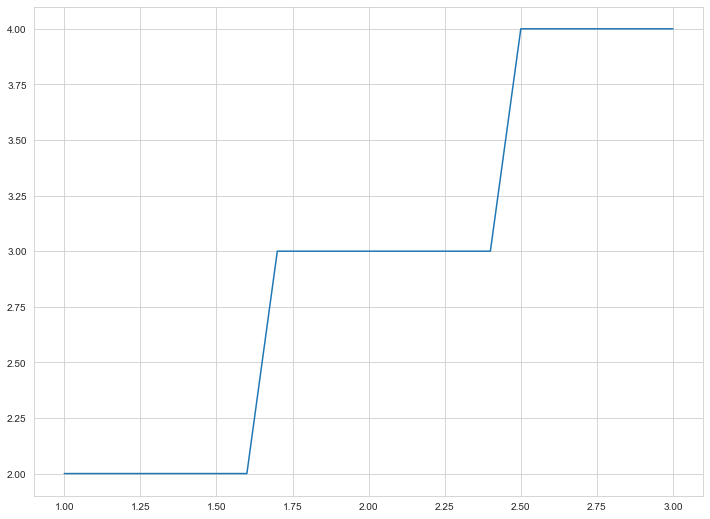

In [33]:
eps_values = np.arange(1, 3.1, 0.1)
clusters =[]

for e in eps_values:
    # мин семпл установил, забежав вперед и посмотрев, что у нас достаточно клеток каждого типа
    model_dbscan = DBSCAN(eps=e, min_samples=700).fit(X)
    clusters.append(len(np.unique(model_dbscan.labels_)))

plt.plot(eps_values, clusters)

0.6105851380444187


Text(0, 0.5, '$TSNE_2$')

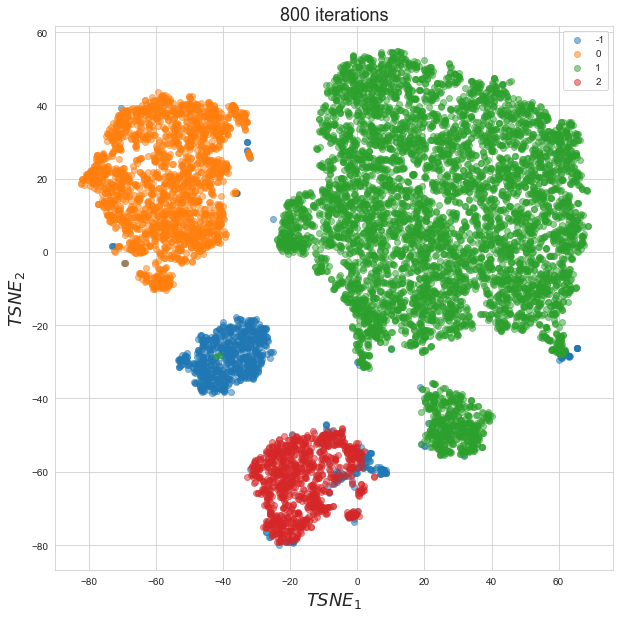

In [34]:
# тут пробовал руками поварьировать eps и посмотреть как меняется силуэт и график
model_dbscan = DBSCAN(eps=2.7, min_samples=700).fit(X)
len(np.unique(model_dbscan.labels_))

labels_dbscan = model_dbscan.labels_
    
print(silhouette_score(X, labels_dbscan))

# построи tSNE график, окрасив данные по соответствующим классам
plt.figure(figsize=(10,10))

labels = np.unique(labels_dbscan)
for l in labels:
    cluster = tsne_res[(labels_dbscan == l), :]
    plt.scatter(cluster[:, 0], cluster[:, 1], alpha=0.5, label=l) 

plt.legend()
plt.title(f"800 iterations", fontsize=18)
plt.xlabel("$TSNE_1$", fontsize=18)
plt.ylabel("$TSNE_2$", fontsize=18)

<font size=3 color='blue'><b>Улучшить силуэт заметно выше 0.61 мне не удалось. При необходимости можно написать функцию по подбору гиперпараметров DBSCAN. Но как мне кажется, в этом случае, у него нет явных преимуществ. Подбор гиперпараметров для него сильно осложнен. Он чуть более склонен перемешивать точки одного кластера с другим, чем тот же KMeans (на графике выше такое перекрывание минимально). Пожалуй лучший результат показал иерархический алгоритм, не смотря на необходимость объединить часть кластеров. <br></b></font>

#### 3.3. Аннотация клеточных типов

4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

* B_cells
* T_cells
* Monocytes
* Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

Для начала нарисуем все это безобразие:

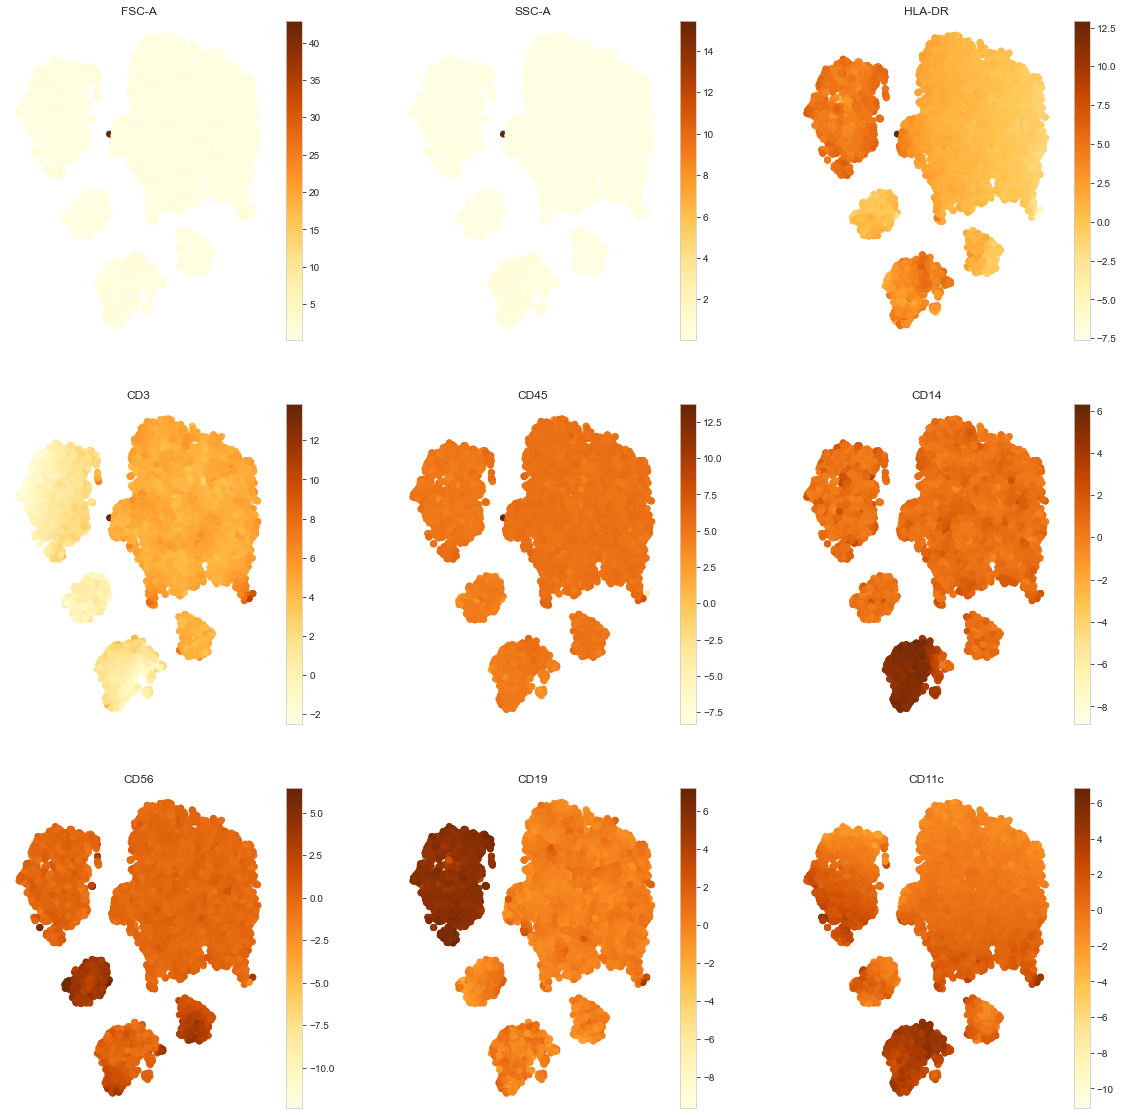

In [35]:
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_data.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res[:, 0], tsne_res[:, 1], 
                         c=fc_data[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Дальше дело за вами, нужно определить клеточный тип для каждого кластера и записать их как значения в словаре.  
  
Информация по маркерам из википедии:
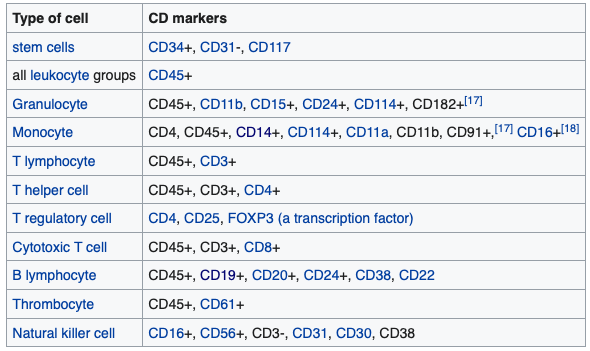  
  
В соответствии с этими данными + по доп. источникам: 
* B_cells: CD45, CD19
* T_cells (lyphocyte): CD3, CD45, HLA-DR(?), CD56
* Monocytes: CD45, CD14, CD11c(?) 
* Other cells: CD11c(?)  
  
Для разделения классов воспроизведем мождель на основе иерархического алгоритма: 

0.6131189244887006


Text(0, 0.5, '$TSNE_2$')

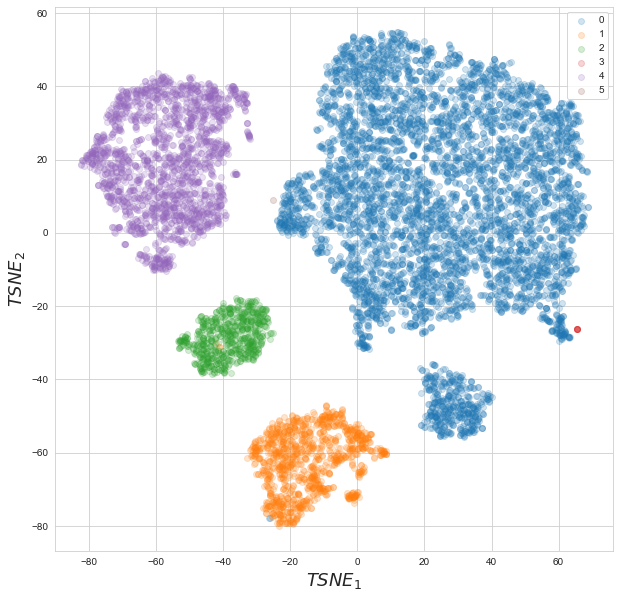

In [36]:
# модель с оптимальными параметрами
agg_model = AgglomerativeClustering(n_clusters=6, affinity='cosine', linkage='average').fit(X)
agg_labels = agg_model.labels_

print(silhouette_score(X, agg_labels))

# построи график в осях tSNE, окрасив данные по соответствующим классам
plt.figure(figsize=(10,10))

for label in np.unique(agg_labels):
    cluster = tsne_res[(agg_labels == label), :]
    plt.scatter(cluster[:, 0], cluster[:, 1], alpha=0.2, label=label) 

plt.legend()
plt.xlabel("$TSNE_1$", fontsize=18)
plt.ylabel("$TSNE_2$", fontsize=18)

**Комментарий:  
Я стремился подбирать модели, которые сразу объединяют два кластера other cells в один. Можно было бы и искать модели, которые хорошо объединяют 5 кластеров, а потом слить два вручную. Как это сделано далее. как было бы лучше? Мне кажется, тут принципиальной разницы нет, но может в какой-то задаче на определенных данных имеет смысл выбрать именно один из подходов.**

Скомбинировав полученный график с информацией о CD-маркерах можем записать следующую аннотацию:

In [37]:
cell_type_cluster_map = {0: "Other_cells", 
                         1: "Monocytes", 
                         2: "T_cells", 
                         3: "Other_cells",
                         4: "B_cells",
                         5: "Other_cells"}

In [38]:
# перенесем метки классов в датасет
labeled_fc_data = fc_data.assign(Population=agg_labels)

#трансформируем метки в типы клеток
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map)

labeled_fc_data.head()

FSC-A     SSC-A    HLA-DR       CD3      CD45      CD14      CD56  \
0  0.722199  0.154232  0.494449  0.512853  4.057328  1.019255  4.007273   
1  0.751073  0.114618  4.671924  0.822042  4.933149  0.159388 -0.216407   
2  1.108188  0.150011 -0.422857  4.006353  5.616384  0.519223  0.783077   
3  0.553310  0.119929  0.345968  3.332310  5.260935  1.481229  0.264846   
4  0.774884  0.076984  4.984963  0.885501  4.562367  0.217117  0.086279   

       CD19     CD11c   Population  
0 -1.406912  0.384406      T_cells  
1  6.034845  0.577039      B_cells  
2 -0.318668 -0.493832  Other_cells  
3  0.694883  3.416960  Other_cells  
4  5.563345  0.471591      B_cells

Посчитайте, как распределены типы клеток:

(array([ 632.,    0.,    0., 2035.,    0.,    0., 6233.,    0.,    0.,
        1100.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

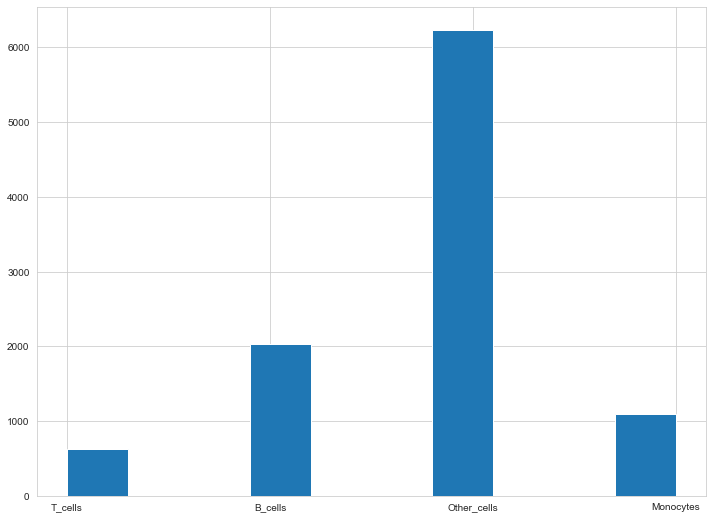

In [39]:
plt.hist(labeled_fc_data.Population)

Сохраните ваши результаты в csv файл, мы сравним их с правильными ответами по метрике `f1_score(average="macro")`, которая хорошо подходит, даже если классы не сбалансированы.

In [40]:
labeled_fc_data.to_csv('../data/labeled_fc_data.csv')

#### 3.4. Автоматическая аннотация

**дополнительные** 5 баллов

Это задание является дополнительным. Вам нужно построить классификатор клеточных типов на основе размеченных вами данных. Пока что мы прошли не так много разных классификаторов, но уже есть из чего выбирать.

Оцените качество полученной модели при помощи `f1_score(average="macro")`. Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов ([помощь](https://elitedatascience.com/imbalanced-classes)).  
  
## Попробуем логистическую регрессию:

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

**Классы в наших данных не сбалансированы. Как с этим быть?**  
**Решения:** https://elitedatascience.com/imbalanced-classes  
**На мой взгляд up-sampling для минорных классов или down-sampling для мадорного класса - может таить скрытые опасности применительно к данным, которые мы разметили самостоятельно в полу-автоматическом режиме. Поэтому более мягкий выход использовать для оптимизации roc-auc метрику. Используем этот вариант:**

In [42]:
# загрузка данных
cell_data = pd.read_csv('../data/labeled_fc_data.csv', index_col=0)

# разделяем предикторы и зависимую переменную
X = cell_data.iloc[:, :-1]
y = cell_data['Population']

y.value_counts()

Other_cells    6233
B_cells        2035
Monocytes      1100
T_cells         632
Name: Population, dtype: int64

In [43]:
# разбиение на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_test.value_counts()

Other_cells    1256
B_cells         406
Monocytes       207
T_cells         131
Name: Population, dtype: int64

In [44]:
# создаем пайплайн и оптимизируем параметры модели
pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('logistic_regressor', LogisticRegression(multi_class='ovr', solver='liblinear'))])

# параметры, тут всего один
parameteres = {'logistic_regressor__penalty': ['l1', 'l2', 'elasticnet', 'none']}

# инициализируем поиск ооптимальных параметров с 5-fold кросс-валидацией, метрика - f1
grid = GridSearchCV(pipeline, param_grid=parameteres, scoring=roc_auc_score, cv=5)

# поиск оптимальных параметров
grid.fit(X_train, y_train)
print(grid.best_params_)

{'logistic_regressor__penalty': 'l1'}


In [45]:
# используем оптимальные параметры
pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('logistic_regressor', LogisticRegression(penalty='l1', multi_class='ovr', solver='liblinear'))])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic_regressor',
                 LogisticRegression(multi_class='ovr', penalty='l1',
                                    solver='liblinear'))])

In [46]:
y_pred_proba = pipeline.predict_proba(X_test)
y_pred = pipeline.predict(X_test)

print(f'ROC-AUC is {roc_auc_score(y_test, y_pred_proba, multi_class="ovr")}')
print(f'f1-score is {f1_score(y_test, y_pred, average="macro")}')

ROC-AUC is 1.0
f1-score is 1.0


### Задание 4. Любимое место

дополнительно 0.5 балла

Расскажите о вашем любимом месте, куда бы вы хотели съездить этой весной, если вы уже там бывали, то прикрепите фотографию)

Съезить весной... хехе. Ну все же очень скучаю по Испании. По Барселоне, по коста-брава. Очень надеюсь вернуться!
<div>
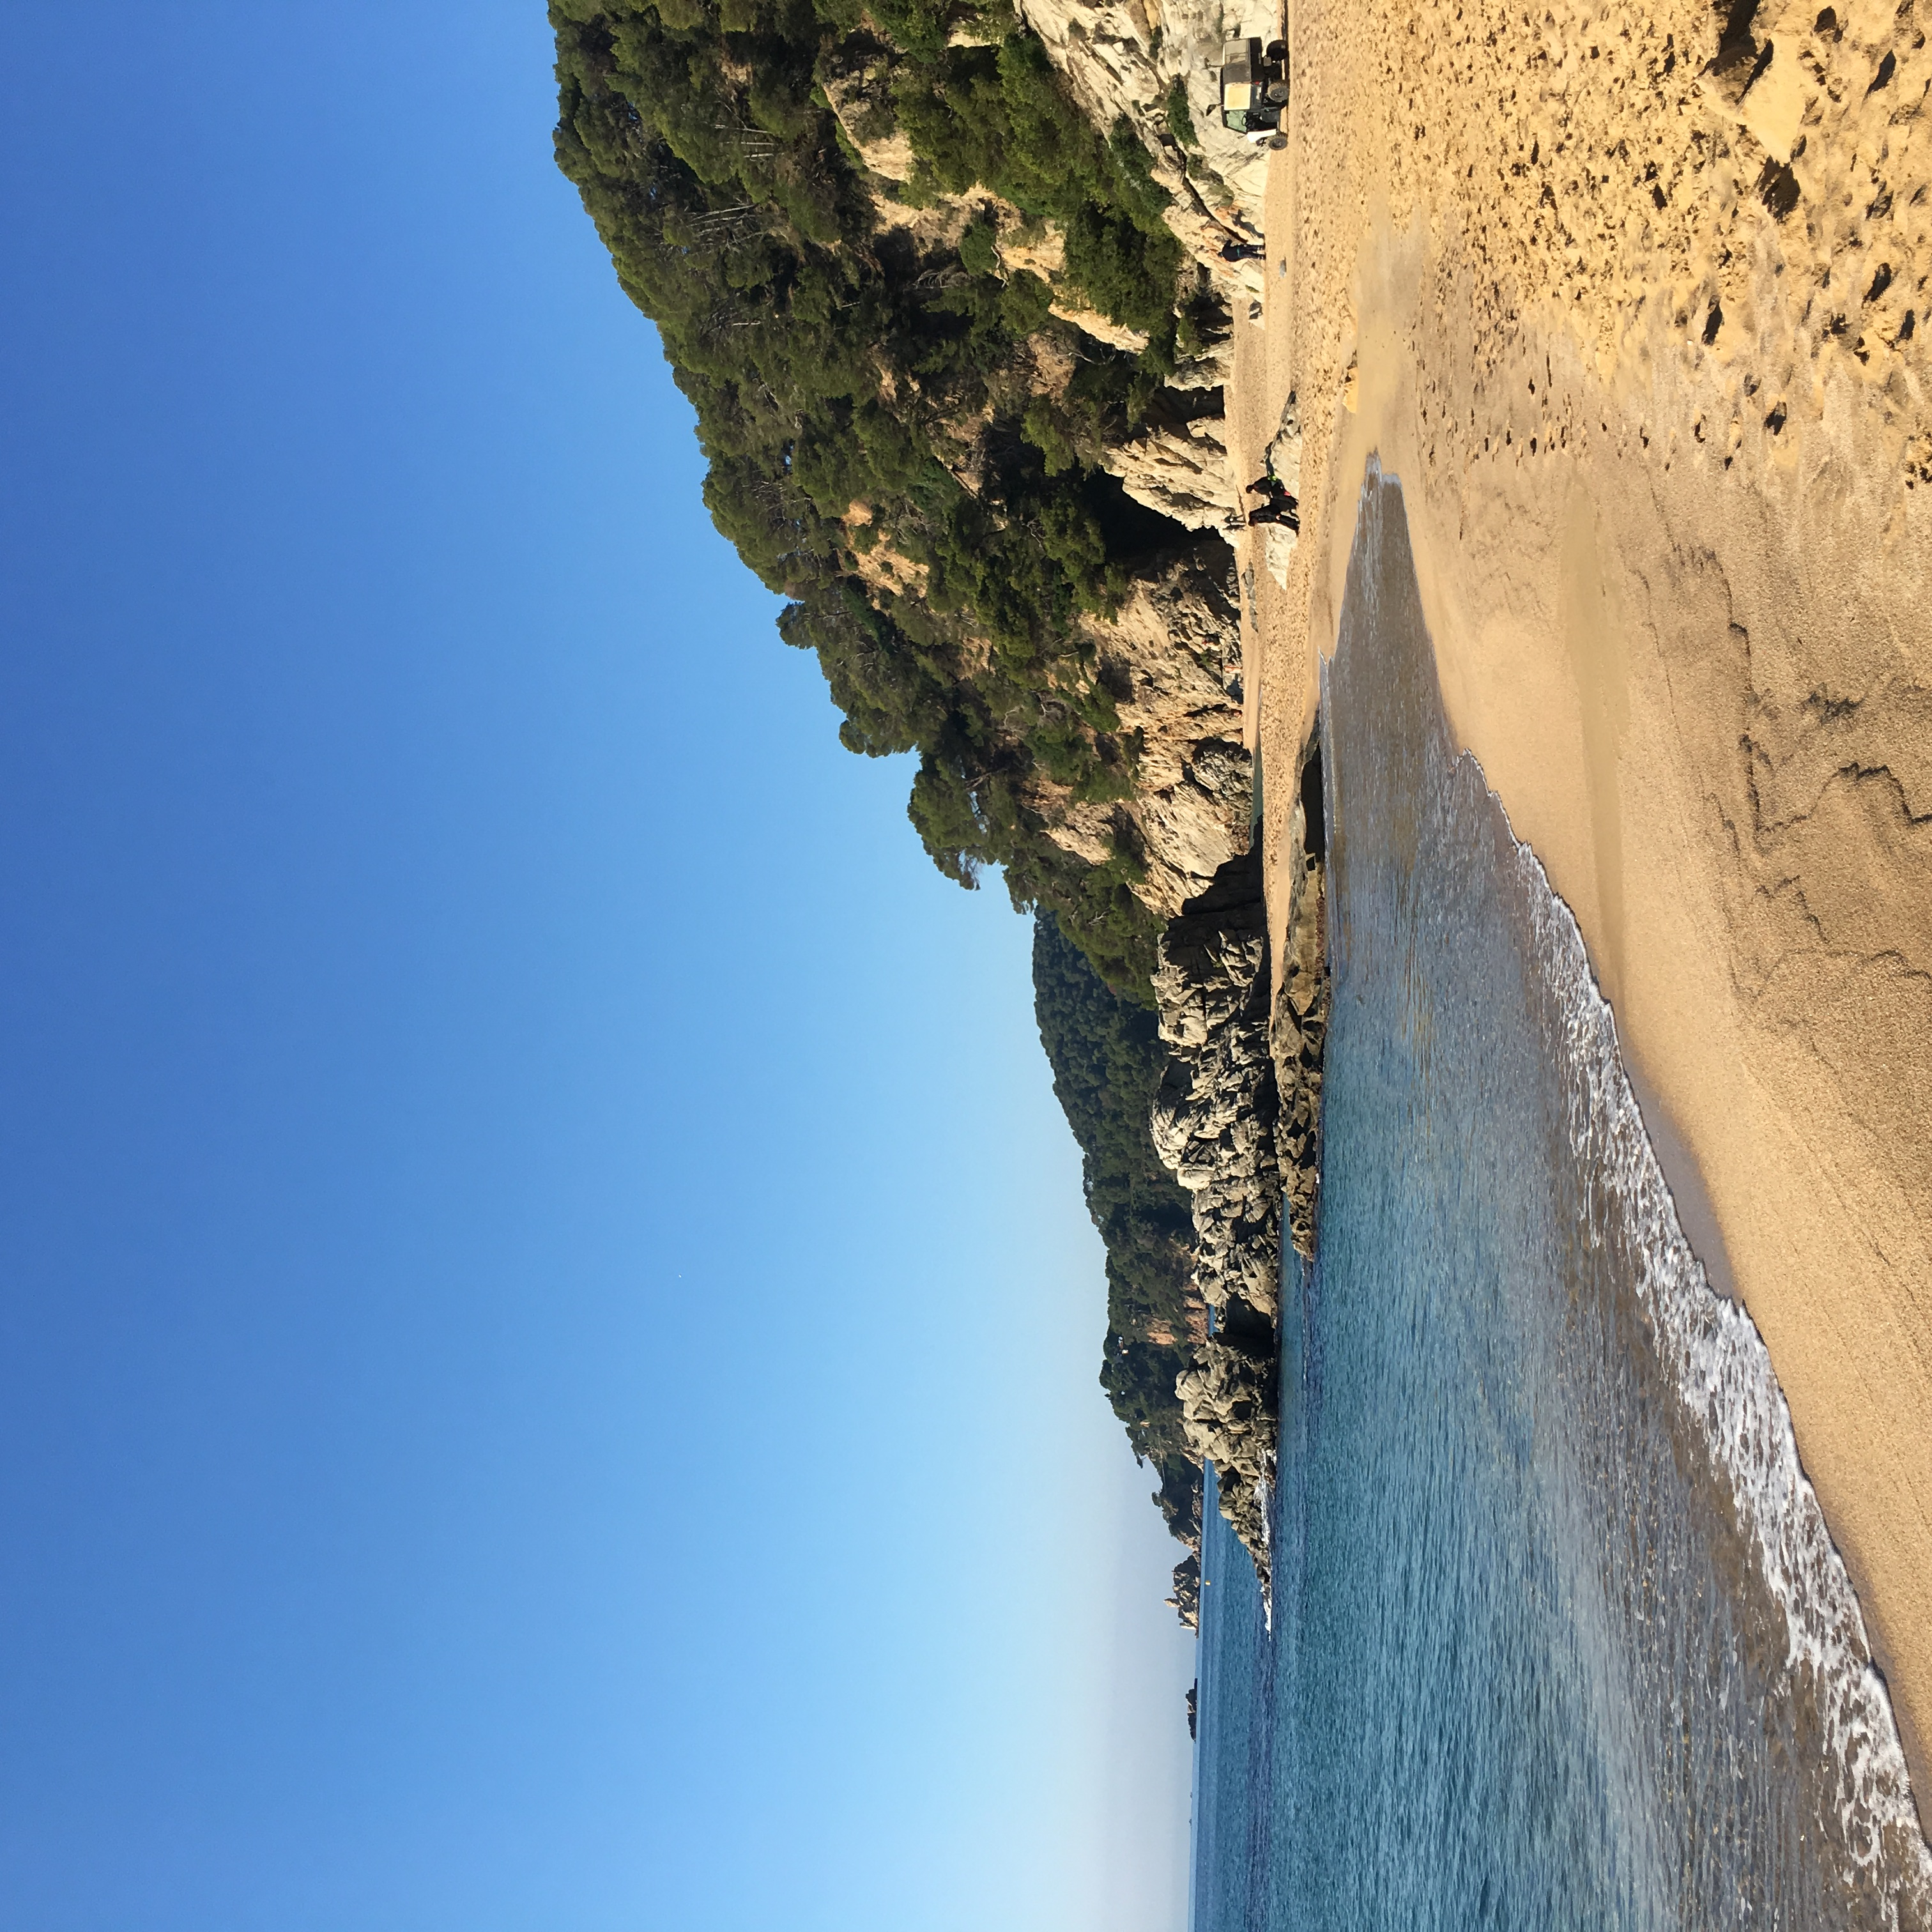
</div>

### Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

Задание как всегда прекрасно подготовлено! Спасибо. Было интересно и приятно поработать с биологическими данными. Правда вводит в недоумение - почему клеточных типов 4, а кластеров в tSNE 5.  